## P3: OpenStreetMap Data Case Study
*** -- *** 

## Map Area

#### 1. Schaumburg, IL, United States

Source of the map and OSM data file: 

http://www.openstreetmap.org/#map=12/42.0152/-88.0300

https://mapzen.com/data/metro-extracts/your-extracts/c24fa71992dc

This is a map of Schaumburg and neighboring towns representing my data. I’m interested to see what database querying reveals. 

( Image: ScreenShot_03.PNG )

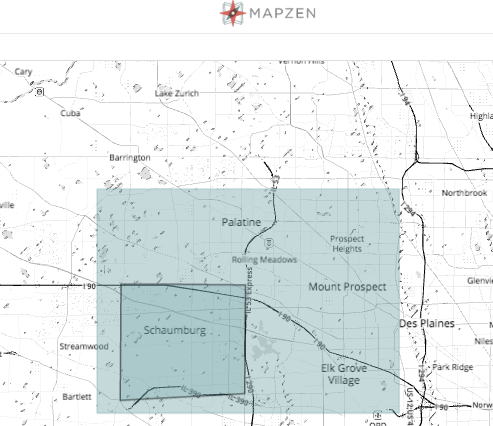

In [1]:
from IPython.display import Image
Image(filename='Images/ScreenShot_03.PNG')

## Overview of the Data

The choice of the databases for this project: SQL.

The extract was created on 2016 September 02, at 04:53 PM. OSM XML compressed file size is 3.7MB, uncompressed size 53.5MB.

To get the feeling on how much of which data I can expect to have in the map, I did the iterative parsing to process the map file and find out not only what tags are there, but also how many. 

( Python file: Iterative_Parsing.py, Image: ScreenShot_09.PNG )

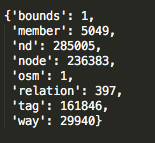

In [2]:
Image(filename='Images/ScreenShot_09.PNG')

To see if there are any potential problems I explored the data a bit more.
Before processing the data and adding it into the database, I checked the "k" value for each "tag".

The count of each of four tag categories in a dictionary:
1. "lower", for tags that contain only lowercase letters and are valid,
2. "lower_colon", for otherwise valid tags with a colon in their names,
3. "problemchars", for tags with problematic characters, and
4. "other", for other tags that do not fall into the other three categories.

( Python file: Tag_Types.py, Image: ScreenShot_10.PNG )

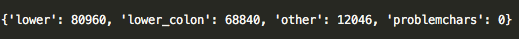

In [3]:
Image(filename='Images/ScreenShot_10.PNG')

The number of unique users who have contributed to the map in this particular area is 390.

( Python file: Exploring_Users.py, Image: ScreenShot_11.PNG )

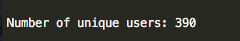

In [4]:
Image(filename='Images/ScreenShot_11.PNG')

## Problems Encountered in the Map

#### 1. Abbreviated street names

I decided to explore the chosen Chicago west suburban area programmatically. After running audit_street_names.py 
and printing the results, one of the problems I have encountered was the inconsistency in naming the streets. See Image 01.  Various abbreviations (with or without dots, upper/ lower case) of the names will be spelled out in full word with the first capital letter. Also, there are values which are assigned to a wrong map feature, e.g a zipcode as a street name.  I am not planning to remove these values.

( Python file: audit_street_names.py, Image: ScreenShot_01.PNG )

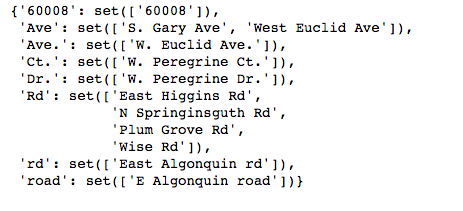

In [5]:
Image(filename='Images/ScreenShot_01.PNG')

#### 2. Abbreviated street directions.

The other inconsistency is the street directions. Various abbreviations. All street directions will be spelled out in full word with the first capital letter, e.g.  W -> West, E -> East. See image 01.

(Image: ScreenShot_01.PNG)

#### 3. Spelling mistake

The spelling mistake was found after running the code with various attribute k values. 

( Python file: audit_street_names.py, Image: ScreenShot_02.PNG )

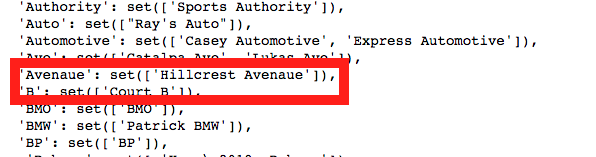

In [6]:
Image(filename='Images/ScreenShot_02.PNG')

#### 3. Inconsistent phone number formats

After running the code with attribute k = 'phone', I found a wide variety in how phone numbers are presented, with regard to spacing and punctuation. I decided to follow  the NANP convention, and chose to use instantly recognizable  and most common format of the number (***) ***-****.

( Python file: audit_street_names.py, Image: ScreenShot_07.PNG )

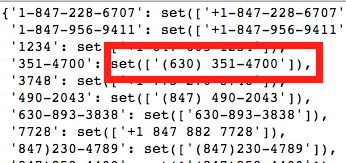

In [7]:
Image(filename='Images/ScreenShot_07.PNG')

***--***

## The Cleaning and Re-shaping Data

Based on my findings, I created a dictionary mapping the incorrect street names to correct values. 

( Python file: data.py, Image: ScreenShot_12.PNG )

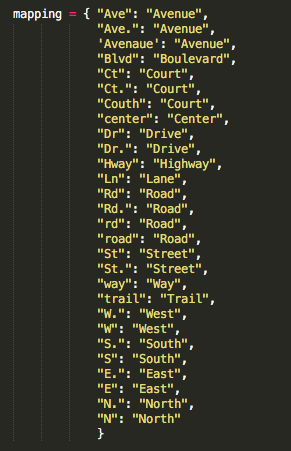

In [8]:
Image(filename='Images/ScreenShot_12.PNG')

The street names were fixed, cleaned and updated using function update_name(name, mapping)

( Python file: data.py, ways_tags.csv, ScreenShot_15.PNG )

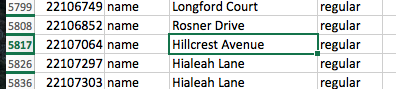

In [9]:
Image(filename='Images/ScreenShot_15.PNG')

With regular expressions pattern I checked for various formats of the phone number and made them uniform format with function update_phone(child_dict)

( Python file: data.py, nodes_tags.csv, Image: ScreenShot_13.PNG, ScreenShot_14.PNG )

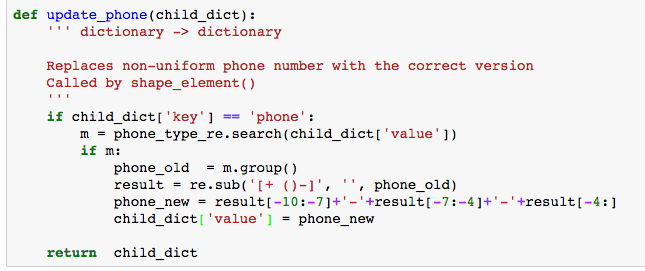

In [10]:
Image(filename='Images/ScreenShot_14.PNG')

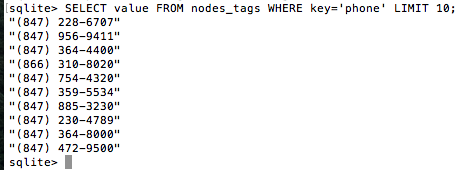

In [11]:
Image(filename='Images/ScreenShot_13.PNG')

## Overview of the Data in my Database

I created a database Schaumburg.db consisting of 5 tables. 

( Image: ScreenShot_16.PNG )

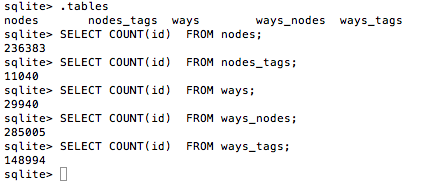

In [12]:
Image(filename='Images/ScreenShot_16.PNG')

To get started, I was curious how many restaurants there are in my town and nearbay. Plenty of choices.

( Image: ScreenShot_18.PNG )

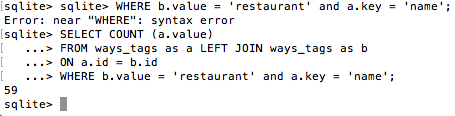

In [13]:
Image(filename='Images/ScreenShot_18.PNG')

And here is beginning of the restaurant list:

( Image: ScreenShot_17.PNG )

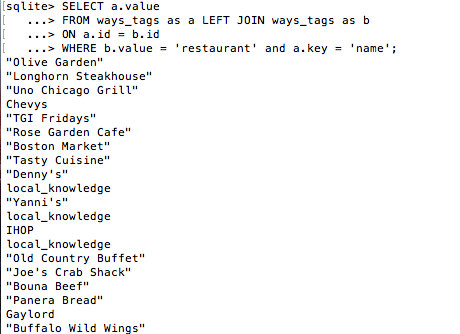

In [14]:
Image(filename='Images/ScreenShot_17.PNG')

And only one restaurant which serves Vietnamese cuisine.

( Image: ScreenShot_19.PNG )

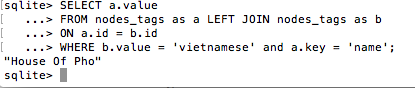

In [15]:
Image(filename='Images/ScreenShot_19.PNG')

Some other observations:

Found secondary level tags of the node 'node' element, which k atribute holds 'created_by' value. Not sure if this information has any value for the map.

&lt;tag k="created_by" v="Potlatch 0.10b"/&gt;

Some key attributes with value = 'building' lists an address instead of the name:

sqlite> SELECT a.value FROM nodes_tags as a LEFT  JOIN nodes_tags as b ON a.id = b.id WHERE a.key = 'name'  and b.key = 'building' ORDER BY a.value;

>999 East Touhy


Most of the schools have no addresses listed. School count:

sqlite> SELECT COUNT(a.value) FROM nodes_tags as a LEFT  JOIN nodes_tags as b ON a.id = b.id WHERE b.value = 'school' and a.key = 'name' ORDER BY a.value;

>95

School with the address:

sqlite> SELECT COUNT(a.value) FROM nodes_tags as a LEFT  JOIN nodes_tags as b ON a.id = b.id WHERE b.value = 'school' and a.key = 'street' ORDER BY a.value;            
> 1

I checked, how many Churches  are in the area:

sqlite> SELECT COUNT(a.value) FROM nodes_tags as a LEFT  JOIN nodes_tags as b ON a.id = b.id WHERE b.value = 'place_of_worship' and a.key = 'name' ORDER BY a.value;
>81

And this query explains why the number of churches is so high. Because  of double entries:

sqlite> SELECT a.value FROM nodes_tags as a LEFT  JOIN nodes_tags as b ON a.id = b.id WHERE b.value = 'school' and a.key = 'name' ORDER BY a.value; 
> ..

>Robert Frost Elementary School

>Robert Frost Elementary School

>Saint John School

>Saint Johns School

>..

sqlite> SELECT a.value FROM nodes_tags as a LEFT  JOIN nodes_tags as b ON a.id = b.id WHERE b.value = 'place_of_worship' and a.key = 'name' ORDER BY a.value;
> First United Methodist Church

>First United Methodist Church

>Immanuel Lutheran Church

>Immanuel Lutheran Church

>Saint Johns Church

>Saint Johns Church

>Saint Martin's Episcopal Church

>Saint Nicholas Episcopal Church

>..


Full address as a house number value

sqlite> SELECT b.value FROM nodes_tags as a LEFT  JOIN nodes_tags as b ON a.id = b.id WHERE b.key = 'housenumber' and a.key = 'name';

>2310 South Elmhurst Road

## Conclusion

After taken a look at the map, I realized that there could be done a lot of stuff to improve my neighborhood map. To list a few - almost all schools and churches have no listed address features. That alone would be a ton of work. I would need to do more research to get to know the process of getting involved. But, I think, there is a very active community to join and get a help. 

### Recources

https://mapzen.com/data/metro-extracts/your-extracts/c24fa71992dc

http://wiki.openstreetmap.org/wiki/OSM_XML

http://wiki.openstreetmap.org/wiki/Map_Features

http://www.w3schools.com/sql/

http://stackoverflow.com/questions/9751548/how-do-i-correctly-paste-multi-line-xml-snippet-to-github-wiki-when-using-markdo